# 3.3 Classificador de dígitos completo

Para construir um classificador para os quatro dígitos contidos na base, utiliza-se a estratégia **"Um Contra Todos"**.

## Passo a Passo

1. **Escolha de um dígito positivo**  
   Inicialmente, escolhe-se um dígito específico (por exemplo, **0**) para ser a classe **𝑦 = +1**.

2. **Agrupamento dos demais dígitos**  
   Todos os outros dígitos (por exemplo, **1, 4 e 5**) são temporariamente definidos como a classe **𝑦 = −1**.

3. **Treinamento do modelo**  
   O modelo é treinado para distinguir o dígito escolhido (**positivo**) de todos os outros (**negativos**).

4. **Repetição para cada dígito**  
   O processo é repetido para cada dígito que se deseja classificar. Assim, teremos um classificador separado para cada número.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import Perceptron, LogisticRegression, LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin

In [2]:
warnings.filterwarnings("ignore")

## Por que criar duas funções para “Um Contra Todos”?

No projeto de classificação dos dígitos usando a estratégia **“Um Contra Todos”**, precisou-se criar duas funções separadas devido às diferenças fundamentais entre os modelos utilizados: **Regressão Linear** versus **Perceptron / Regressão Logística**.

---

## Regressão Linear

- **Saída do modelo:** valores contínuos (float), que podem assumir qualquer valor real.
- **Problema:** não fornece diretamente classes discretas (+1/-1).
- **Solução:** aplicar um **limiar (threshold)** para converter a saída contínua em classe binária


##  Perceptron e Regressão Logística

- **Saída do modelo:** classes discretas (+1 ou -1) diretamente.

- **Vantagem:** não precisa de threshold, pois o próprio predict() retorna a decisão binária.

In [18]:
def treinar_um_contra_todos(classificador, X_train, y_train, digitos_alvo=[0, 1, 4]):
    """
    Treina classificadores no esquema Um-Contra-Todos (One-vs-All)
    para os dígitos especificados. Retorna os classificadores e escalers.
    """
    classificadores_dict = {}

    for idx, digito in enumerate(digitos_alvo):
        y_bin = np.where(y_train == digito, 1, -1)
        
        # Filtra os dados removendo apenas a classe anterior (para OvA progressivo)
        if idx > 0:
            mask = y_train != digitos_alvo[idx - 1]
            X_train_filtrado = X_train[mask]
            y_bin = y_bin[mask]
        else:
            X_train_filtrado = X_train

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_filtrado)

        clf = classificador()
        clf.fit(X_train_scaled, y_bin)

        classificadores_dict[digito] = (clf, scaler)

    return classificadores_dict

In [25]:
# Recarregar a função
def previsoes(classificador, X_test, y_test, classificadores):
    preds = []
    for x in X_test:
        pred = None
        
        if classificador == LinearRegression:
            for digito, (clf, scaler) in classificadores.items():
                x_scaled = scaler.transform([x])
                y_cont = clf.predict(x_scaled)[0]
                if y_cont >= 0:
                    pred = digito
                    break
        else:
            for digito, (clf, scaler) in classificadores.items():
                x_scaled = scaler.transform([x])
                if clf.predict(x_scaled)[0] == 1:
                    pred = digito
                    break
        if pred is None:
            pred = 5
        preds.append(pred)

    print(f"\nModelo: {classificador.__name__}")
    print(classification_report(y_test, preds, digits=2))
    
    return classificadores, preds


# 3.4 Funçoes de plotagem

In [ ]:
def plot_fronteira_e_matriz(classificadores, X, y, modelo_tipo="LinearRegression", digitos_alvo=[0,1,4]):
    """
    Plota lado a lado: fronteiras de decisão e matriz de confusão
    para classificadores One-vs-All.
    """
    cores_pontos = {0:'orange', 1:'blue', 4:'green', 5:'red'}
    cores_linhas = {0:'red', 1:'blue', 4:'green'}

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # ---------------------------
    # 1️⃣ Fronteiras + Pontos
    # ---------------------------
    ax1 = axes[0]

    # Pontos
    for digito in np.unique(y):
        mask = y == digito
        ax1.scatter(X[mask, 0], X[mask, 1],
                    c=cores_pontos[digito], alpha=0.5, s=20,
                    label=f'Dígito {digito}')

    # Grid
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Fronteiras
    for digito, (modelo, scaler) in classificadores.items():
        grid_scaled = scaler.transform(grid_points)
        if modelo_tipo == "LinearRegression":
            y_cont = modelo.predict(grid_scaled).reshape(xx.shape)
        else:
            y_cont = modelo.predict(grid_scaled).reshape(xx.shape)
            
        ax1.contour(xx, yy, y_cont, levels=[0], colors=cores_linhas[digito],
                    linestyles='--', linewidths=2)

    ax1.set_xlabel("Intensidade")
    ax1.set_ylabel("Simetria")
    ax1.set_title(f"Fronteiras de decisão - {modelo_tipo}")
    ax1.legend()
    ax1.grid(True, linestyle="--", alpha=0.3)

    # ---------------------------
    # 2️⃣ Matriz de Confusão
    # ---------------------------
    # Previsões
    preds = []
    for x in X:
        pred = None
        for digito, (clf, scaler) in classificadores.items():
            x_scaled = scaler.transform([x])
            y_pred = clf.predict(x_scaled)[0]
            if (modelo_tipo == "LinearRegression" and y_pred >= 0) or (y_pred == 1):
                pred = digito
                break
        if pred is None:
            pred = 5
        preds.append(pred)

    cm = confusion_matrix(y, preds, labels=[0,1,4,5])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[0,1,4,5])
    disp.plot(cmap=plt.cm.Blues, ax=axes[1])
    axes[1].set_title("Matriz de Confusão")

    plt.tight_layout()
    plt.show()

In [6]:
def matriz_confusao(y, classificadores):
    cm = confusion_matrix(y, previsoes, labels=[0,1,4,5])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=[0,1,4,5])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Matriz de Confusão")
    plt.show()

---

## Separando os Dados


In [7]:
train = pd.read_csv('dataset/train_redu.csv')
test = pd.read_csv('dataset/test_redu.csv')

In [8]:
X_train = train.drop(columns=['label']).values
y_train = train['label'].values

X_test = test.drop(columns=['label']).values
y_test = test['label'].values

#### Perceptron


Modelo: Perceptron
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       218
           1       1.00      1.00      1.00       292
           4       0.87      1.00      0.93       314
           5       1.00      0.83      0.90       291

    accuracy                           0.95      1115
   macro avg       0.96      0.96      0.96      1115
weighted avg       0.96      0.95      0.95      1115



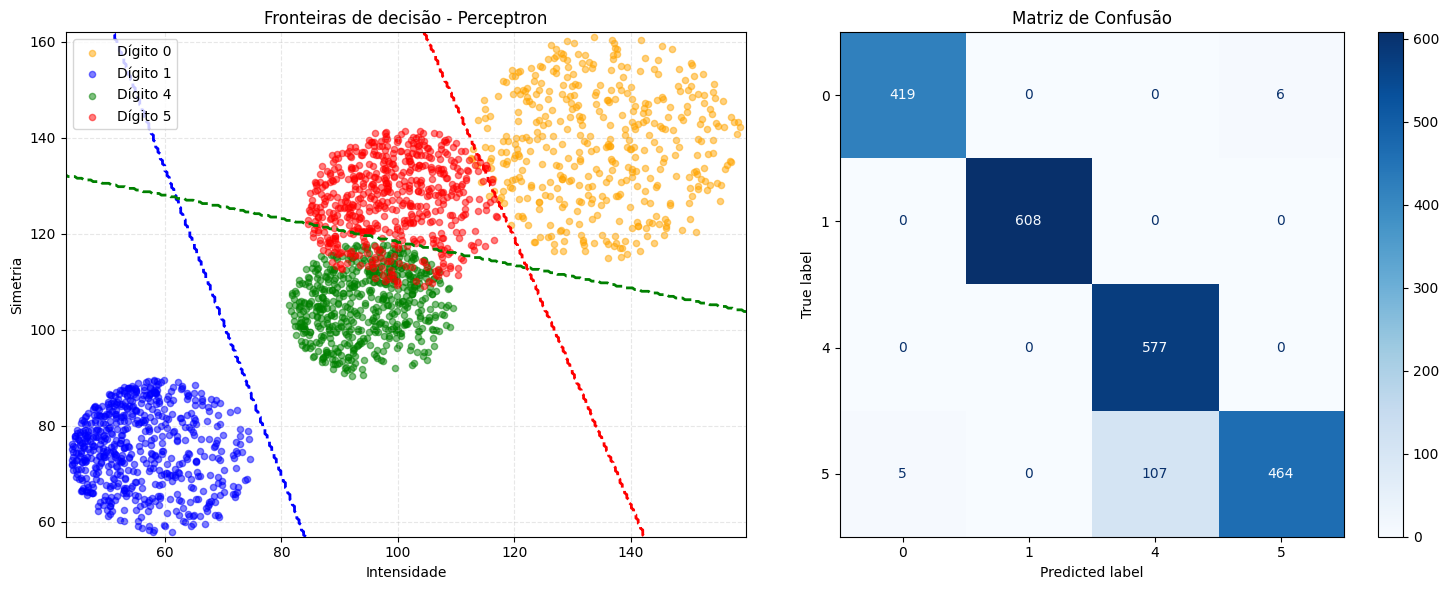

In [21]:
classificadores = treinar_um_contra_todos(Perceptron, X_train, y_train)
classificadores, previsoes = previsoes(Perceptron, X_test, y_test, classificadores)
plot_fronteira_e_matriz(classificadores, X_train, y_train, modelo_tipo="Perceptron")

#### Regressão Linear


Modelo: LinearRegression
              precision    recall  f1-score   support

           0       1.00      0.80      0.89       218
           1       1.00      1.00      1.00       292
           4       0.92      0.98      0.95       314
           5       0.84      0.91      0.87       291

    accuracy                           0.93      1115
   macro avg       0.94      0.92      0.93      1115
weighted avg       0.94      0.93      0.93      1115



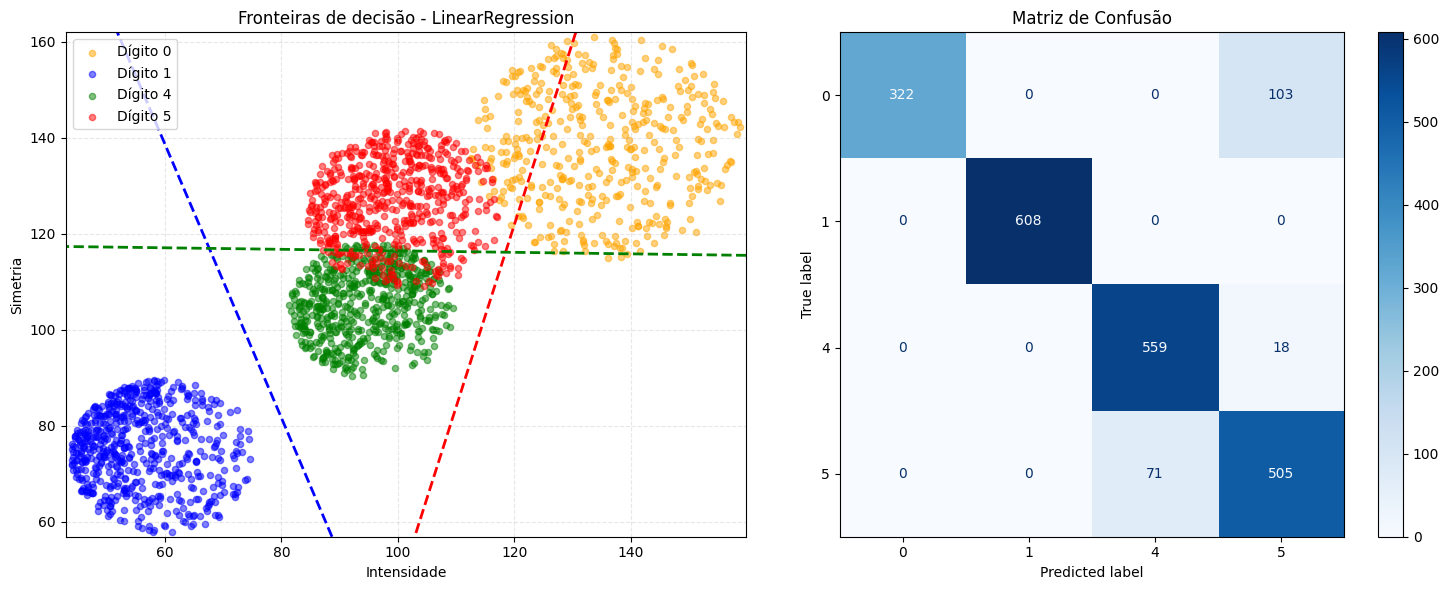

In [26]:
classificadores = treinar_um_contra_todos(LinearRegression, X_train, y_train)
classificadores, preds = previsoes(LinearRegression, X_test, y_test, classificadores)
plot_fronteira_e_matriz(classificadores, X_train, y_train, modelo_tipo="LinearRegression")

#### Regressão Logística


Modelo: LogisticRegression
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       218
           1       1.00      1.00      1.00       292
           4       0.94      0.95      0.94       314
           5       0.94      0.93      0.94       291

    accuracy                           0.97      1115
   macro avg       0.97      0.97      0.97      1115
weighted avg       0.97      0.97      0.97      1115



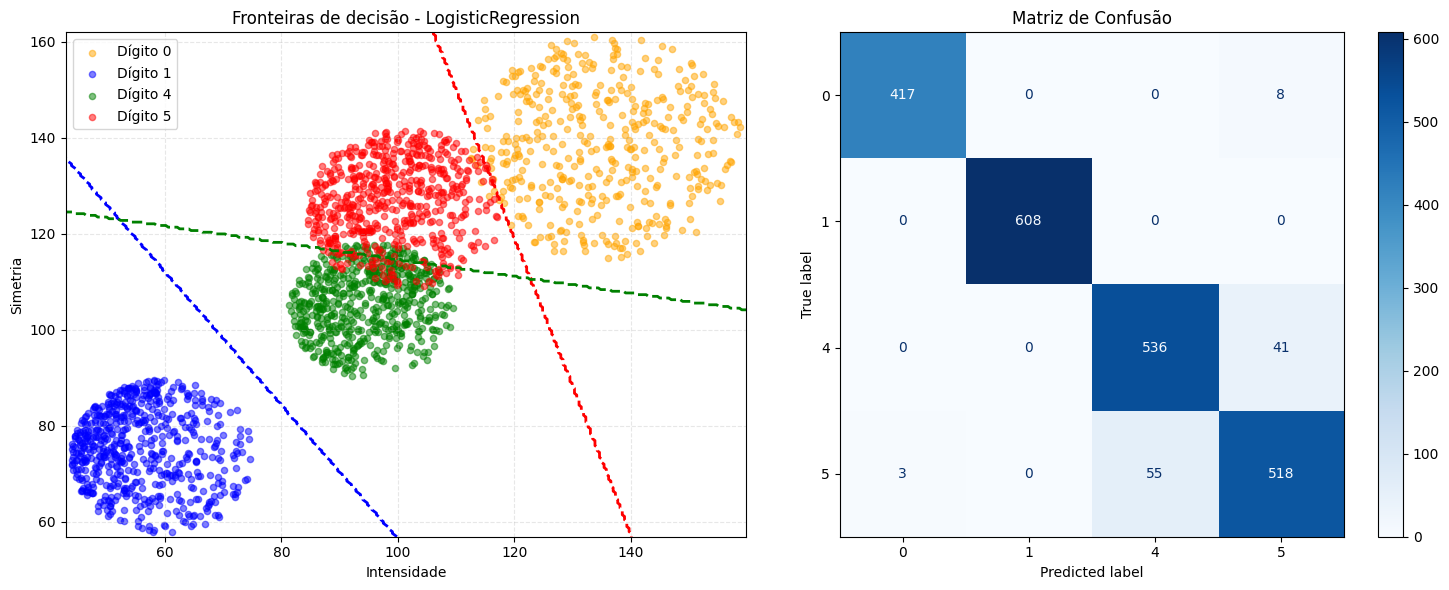

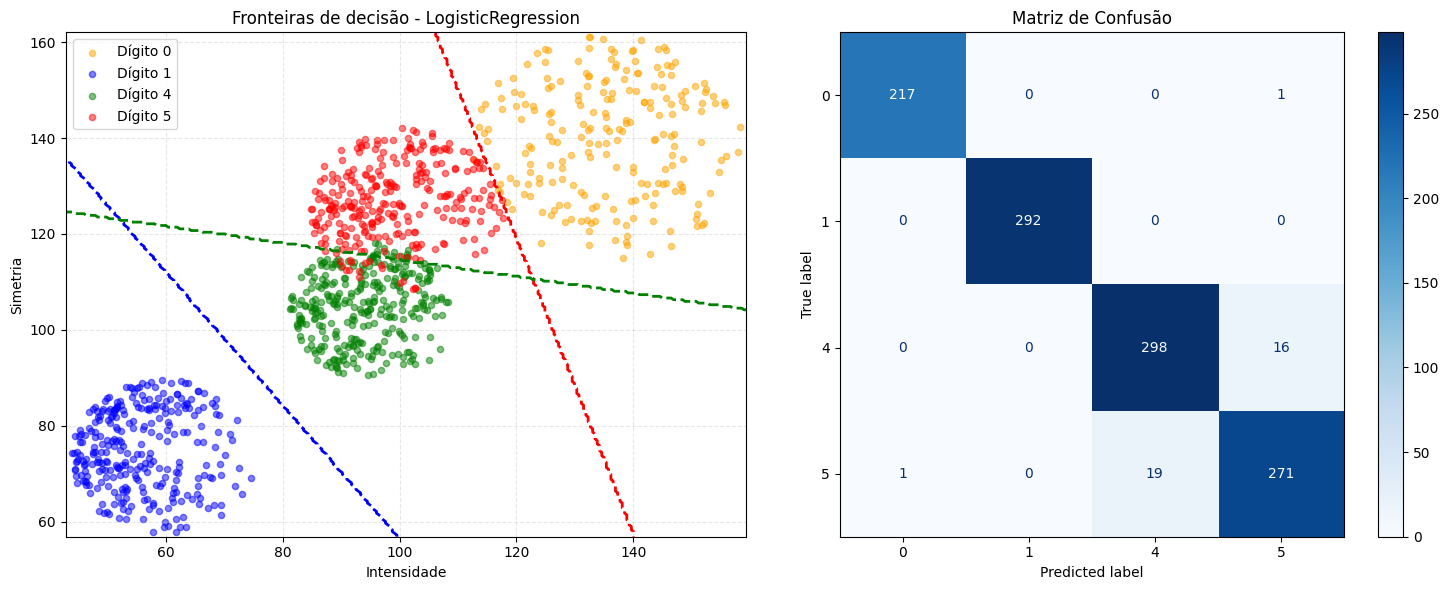

In [29]:
# Para LogisticRegression
classificadores = treinar_um_contra_todos(LogisticRegression, X_train, y_train)
classificadores, preds = previsoes(LogisticRegression, X_test, y_test, classificadores)
plot_fronteira_e_matriz(classificadores, X_train, y_train, modelo_tipo="LogisticRegression")
plot_fronteira_e_matriz(classificadores, X_test, y_test, modelo_tipo="LogisticRegression")

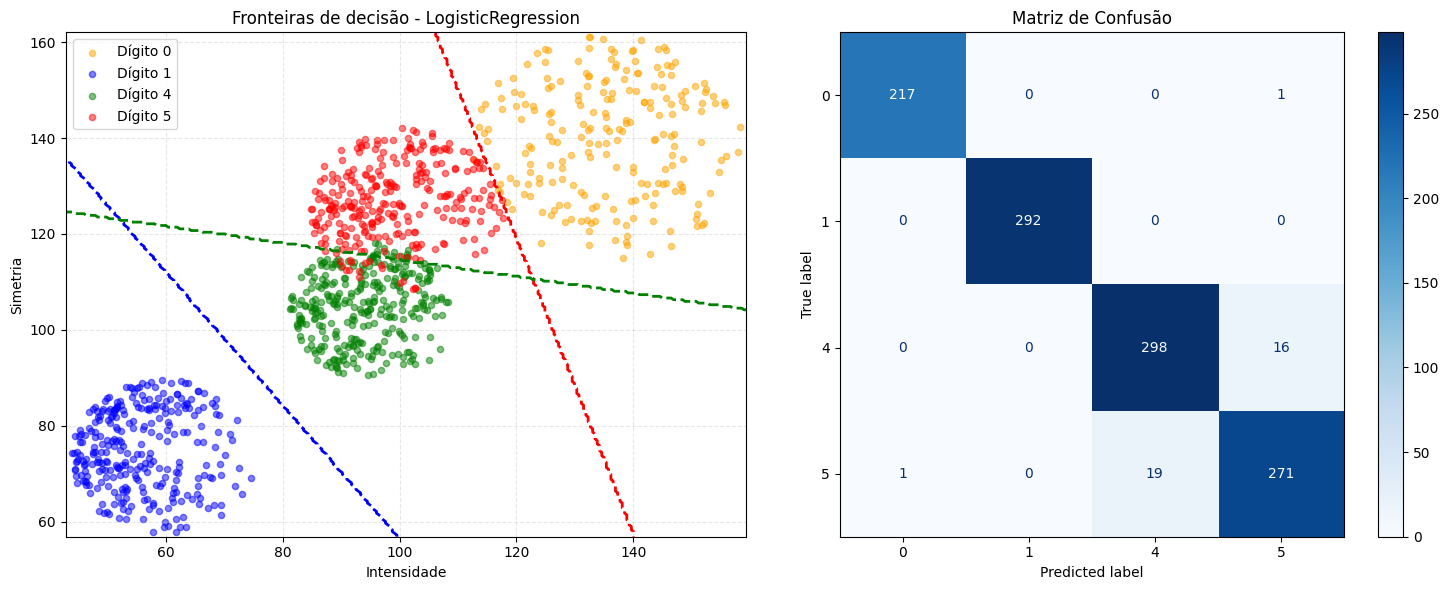

In [28]:
plot_fronteira_e_matriz(classificadores, X_test, y_test, modelo_tipo="LogisticRegression")

# 4. Implementações avançadas

## Predição com weight decay

In [ ]:
def logistic_ova(X_train, y_train, digitos_alvo=[0,1,4,5], lambda_val=0.1):
    """
    Treina classificadores Logistic Regression Um-Contra-Todos com weight decay (L2).
    
    Retorna:
        classificadores: dict {digito: (modelo, scaler)}
    """
    C_val = 1 / lambda_val
    classificadores = {}

    for digito in digitos_alvo:
        y_bin = np.where(y_train == digito, 1, -1)

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)

        clf = LogisticRegression(penalty='l2', C=C_val, solver='lbfgs', max_iter=1000)
        clf.fit(X_train_scaled, y_bin)

        classificadores[digito] = (clf, scaler)

    return classificadores

In [53]:
def prever_ova(classificadores, X, fallback=5):
    preds = []
    for x in X:
        pred = fallback
        for digito, (clf, scaler) in classificadores.items():
            x_scaled = scaler.transform([x])
            if clf.predict(x_scaled)[0] == 1:
                pred = digito
                break
        preds.append(pred)
    return np.array(preds)

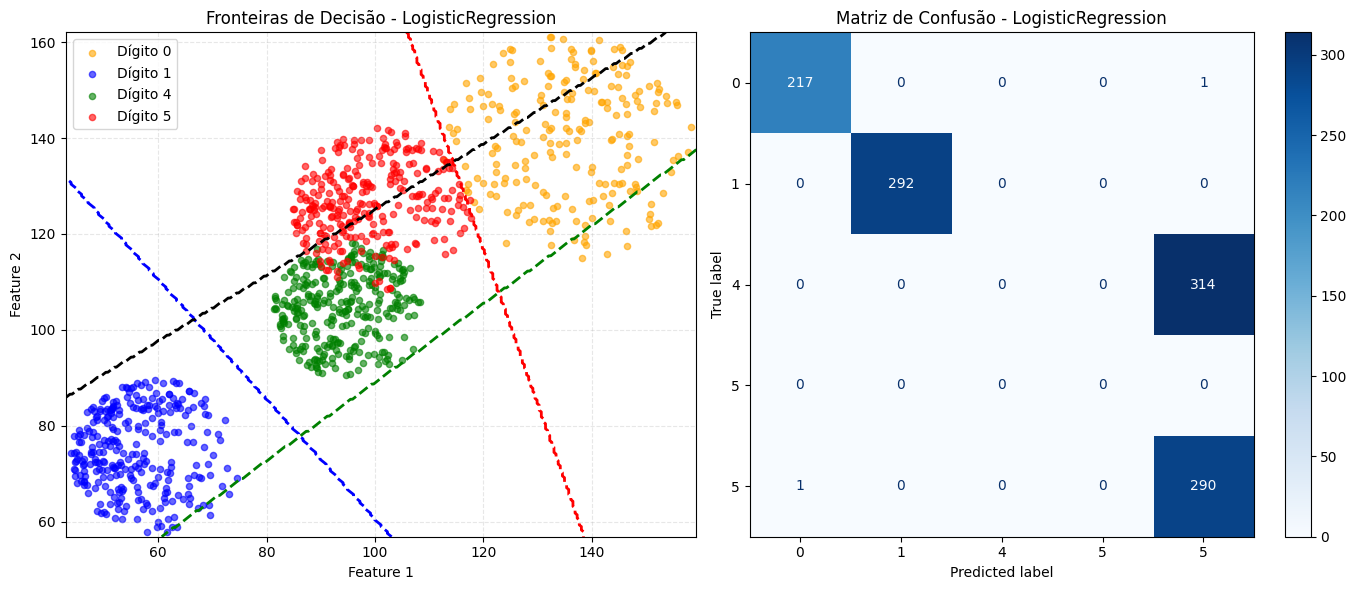

In [56]:
lambda_val = 0.1  # regularização

# Treina os classificadores Logistic Regression Um-Contra-Todos
classificadores = logistic_ova(X_train, y_train, digitos_alvo=[0,1,4,5], lambda_val=lambda_val)

# Plotar fronteiras + matriz de confusão usando dados de teste
plot_fronteira_e_matriz(classificadores, X_test, y_test, modelo_tipo="LogisticRegression", digitos_alvo=[0,1,4,5], fallback=5)


## Melhor ordem de teste

In [ ]:
import itertools

# TESTESSSSS

In [33]:
import itertools

In [34]:
def otimizar_ordem_um_contra_todos(modelo_clf, X_train, y_train, X_test, y_test, digitos_alvo=[0,1,4,5]):
    """
    Testa todas as permutações da ordem dos dígitos no esquema Um-Contra-Todos
    e retorna a ordem que produz a maior acurácia global no conjunto de teste.
    """
    melhor_ordem = None
    melhor_acuracia = 0
    melhor_classificadores = None
    melhor_preds = None

    # Todas as permutações possíveis
    for ordem in itertools.permutations(digitos_alvo):
        # Treina os classificadores nessa ordem
        classificadores = {}
        for idx, digito in enumerate(ordem):
            y_bin = np.where(y_train == digito, 1, -1)
            if idx > 0:
                mask = y_train != ordem[idx - 1]
                X_train_filtrado = X_train[mask]
                y_bin = y_bin[mask]
            else:
                X_train_filtrado = X_train

            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train_filtrado)

            clf = modelo_clf()
            clf.fit(X_train_scaled, y_bin)

            classificadores[digito] = (clf, scaler)

        # Faz previsões usando essa ordem
        preds = []
        for x in X_test:
            pred = None
            for digito in ordem:
                clf, scaler = classificadores[digito]
                x_scaled = scaler.transform([x])
                y_pred = clf.predict(x_scaled)[0]
                if (modelo_clf == LinearRegression and y_pred >= 0) or (y_pred == 1):
                    pred = digito
                    break
            if pred is None:
                pred = 5  # caso nenhum classificador reconheça
            preds.append(pred)

        # Calcula acurácia
        acc = accuracy_score(y_test, preds)

        if acc > melhor_acuracia:
            melhor_acuracia = acc
            melhor_ordem = ordem
            melhor_classificadores = classificadores
            melhor_preds = preds

    print(f"Melhor ordem: {melhor_ordem}, Acurácia: {melhor_acuracia:.4f}")
    return melhor_classificadores, melhor_preds, melhor_ordem


In [41]:
classificadores, preds, ordem = otimizar_ordem_um_contra_todos(
    Perceptron, X_train, y_train, X_test, y_test, digitos_alvo=[0,1,4,5]
)

Melhor ordem: (0, 1, 4, 5), Acurácia: 0.9543


In [ ]:
classificadores, preds, ordem = otimizar_ordem_um_contra_todos(
    LinearRegression, X_train, y_train, X_test, y_test, digitos_alvo=[0,1,4,5]
)

Melhor ordem: (1, 4, 0, 5), Acurácia: 0.9363


In [ ]:
classificadores, preds, ordem = otimizar_ordem_um_contra_todos(
    LogisticRegression, X_train, y_train, X_test, y_test, digitos_alvo=[0,1,4,5]
)

Melhor ordem: (0, 1, 4, 5), Acurácia: 0.9668
